## TODO:

- Change to not pick a single reference isoform


- Need another metric as well as pct ID to take into account gaps:
    - gaps in domain alignment 
    

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from Bio import Align

from poibin import PoiBin

from data_loading import load_valid_isoform_clones, load_annotated_6k_collection

In [2]:
tfs = load_annotated_6k_collection()

In [3]:
doms = pd.read_excel('../../data/internal/TF_reg_domain_2019-08-13.xlsx',
                   sheet_name='Sheet1')
doms = (doms.loc[:, ['symbol', 'Domain type', 'Domain sequence', 'aa position']]
        .rename(columns={'symbol': 'hgnc_gene_symbol',
                         'Domain type': 'type',
                         'Domain sequence': 'aa_seq',
                         'aa position': 'pos'}))
doms = doms.dropna()
doms['aa_seq'] = doms['aa_seq'].str.replace(' ', '')
if doms['hgnc_gene_symbol'].isnull().any():
    raise UserWarning('Missing gene name')
# removed because NANOG no loger in there
#if not doms['hgnc_gene_symbol'].isin(tfs).all():
#    raise UserWarning('incorrect gene name', doms.loc[~doms['hgnc_gene_symbol'].isin(tfs),
#'hgnc_gene_symbol'])
renaming_dom_type = {'Repression (dimerization)': 'Repression',
                     'Activation/Repression': 'Regulatory',
                     'Regulatory domain': 'Regulatory'}
doms['type'] = doms['type'].map(lambda x: renaming_dom_type.get(x, x))
doms['reg_dom_id'] = (doms['hgnc_gene_symbol'] + 
                      '_' + 
                      (doms.groupby('hgnc_gene_symbol').cumcount() + 1).astype(str))
if doms['reg_dom_id'].duplicated().any():
    raise UserWarning('something went wrong')
doms = doms.set_index('reg_dom_id')

doms['type'].value_counts()

Activation                177
Repression                 85
Predicted repression       81
DNA binding inhibition      5
Regulatory                  2
Name: type, dtype: int64

In [27]:
doms['hgnc_gene_symbol'].nunique()

228

In [4]:
iso = load_valid_isoform_clones()

In [5]:
# What should the output look like?

# Two tables: 
#   1. remapped domains to all isoform which is good match, containing start / end
#   2. one row for each domain and each isoform with how much of domain is in there

In [5]:
doms.head()

,hgnc_gene_symbol,type,aa_seq,pos
reg_dom_id,,,,
CREB3L3_1,CREB3L3,Activation,MNTDLAAGKMASAACSMDPIDSFELLDLLFDRQDGILRHVELGEGW...,1-149 (Q68CJ9-1)
ELK3_1,ELK3,Activation,SLTPAFFTAQTPNGLLLTPSPLLSSIHFWSSLSPVAPLSPARLQGP...,325-407 (P41970-1)
ELK3_2,ELK3,Repression,NPPDAFKAIKTEKLEEPPEDSPPVEEVRTVIRFVTNK,153-189 (P41970-1)
FOXO3_1,FOXO3,Activation,NLNDGLTENLMDDLLDNITLPPSQPSPTGGLMQRSSSFPYTTKGSG...,377-673 (O43524-1)
GATA1_1,GATA1,Activation,MEFPGLGSLGTSEPLPQFVDPALVSSTPESGVFFPSGPEGLDAAAS...,1-83 (P15976-1)


In [6]:
def num_aa_id(algn):
    a = [algn.target[i] for start, stop in algn.aligned[0] for i in range(start, stop)]
    b = [algn.query[i] for start, stop in algn.aligned[1] for i in range(start, stop)]
    if len(a) != len(b):
        raise UserWarning('Something went wrong')
    return sum(l_a == l_b for l_a, l_b in zip(a, b))


aligner = Align.PairwiseAligner()
aligner.mode = 'local'
aligner.open_gap_score = -1
aligner.extend_gap_score = -1
aligner.target_end_gap_score = 0.0
aligner.query_end_gap_score = 0.0


remapped = []
domain_aligments = {}
PCT_ID_CUTOFF = 95
for i, domain in doms.iterrows():
    is_gene_match = (iso['gene'] == domain['hgnc_gene_symbol'])
    is_perfect_match = is_gene_match & iso['aa_seq'].str.contains(domain['aa_seq'])
    if is_perfect_match.any():
        for __i_iso, row in iso.loc[is_perfect_match, :].iterrows():
            start = row['aa_seq'].index(domain['aa_seq']) + 1
            remapped.append((domain.name,
                                     row['gene'],
                                     row['clone_acc'],
                                     start,
                                     start + (len(domain['aa_seq']) - 1),
                                     100,
                                     0))
    else:
        for __i_iso, row in iso.loc[is_gene_match, :].iterrows():
            alignment = aligner.align(row['aa_seq'], domain['aa_seq'])[0]
            pct_id = 100 * (num_aa_id(alignment) / len(domain['aa_seq']))
            if pct_id >= PCT_ID_CUTOFF:
                domain_aligments[(row['clone_acc'], domain.name)]  = alignment
                n_gaps = alignment.__str__().split()[0].count('-')
                start = alignment.aligned[0][0][0] + 1
                stop = alignment.aligned[0][-1][1]
                remapped.append((domain.name,
                                         domain['hgnc_gene_symbol'],
                                         row['clone_acc'],
                                         start,
                                         stop,
                                         pct_id,
                                         n_gaps))
remapped = pd.DataFrame(remapped, columns=['reg_dom_id',
                                                           'gene', 
                                                           'clone_acc', 
                                                           'start', 
                                                           'end', 
                                                           'pct_match',
                                                           'n_gaps_in_iso_align'])

In [7]:
remapped.sort_values('pct_match').head(20)

,reg_dom_id,gene,clone_acc,start,end,pct_match,n_gaps_in_iso_align
358,ZNF415_1,ZNF415,ZNF415|4/4|06H04,6,45,95.238095,0
360,ZNF415_2,ZNF415,ZNF415|3/4|06A06,6,45,97.560976,0
359,ZNF415_2,ZNF415,ZNF415|2/4|06C05,6,45,97.560976,0
361,ZNF415_2,ZNF415,ZNF415|4/4|06H04,6,45,97.560976,0
41,ZNF317_2,ZNF317,ZNF317|1/2|09H11,57,96,97.560976,0
357,ZNF415_1,ZNF415,ZNF415|3/4|06A06,5,45,97.619048,0
356,ZNF415_1,ZNF415,ZNF415|2/4|06C05,5,45,97.619048,0
210,ZNF101_1,ZNF101,ZNF101|2/2|04B05,3,44,97.619048,0
7,MEF2A_1,MEF2A,MEF2A|1/2|12D08,86,499,98.104265,8
214,ZNF19_1,ZNF19,ZNF19|1/2|12D05,14,73,98.333333,0


In [8]:
remapped.sort_values('n_gaps_in_iso_align', ascending=False).head(20)

,reg_dom_id,gene,clone_acc,start,end,pct_match,n_gaps_in_iso_align
7,MEF2A_1,MEF2A,MEF2A|1/2|12D08,86,499,98.104265,8
0,CREB3L3_1,CREB3L3,CREB3L3|1/2|07C03,1,148,99.328859,1
167,RORA_1,RORA,RORA|2/2|05H06,217,329,99.122807,1
46,ZNF607_1,ZNF607,ZNF607|1/2|04H08,7,66,98.360656,1
400,HNF4A_3,HNF4A,HNF4A|2/6|10H07,333,347,100.000000,0
394,GATA2_2,GATA2,GATA2|3/4|12A02,396,466,100.000000,0
395,HNF4A_1,HNF4A,HNF4A|1/6|10D08,1,50,100.000000,0
396,HNF4A_1,HNF4A,HNF4A|4/6|10A10,1,50,100.000000,0
397,HNF4A_2,HNF4A,HNF4A|1/6|10D08,368,474,100.000000,0
398,HNF4A_2,HNF4A,HNF4A|2/6|10H07,346,452,100.000000,0


In [9]:
(remapped.loc[remapped['pct_match'] == 100, 'reg_dom_id'].nunique(), 
 remapped.loc[remapped['pct_match'] >= 95, 'reg_dom_id'].nunique(),
 doms.shape[0])

(309, 320, 350)

In [ ]:
remapped

In [18]:
# answering clarissa's question
clones = load_valid_isoform_clones()
clones.head()

,gene,clone_acc,aa_seq,num_aa,is_novel_isoform
0,AEBP2,AEBP2|2/3|05F03,MDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYNCCWDQCQACFNSS...,268,True
1,AEBP2,AEBP2|3/3|05E07,MYTRRYSSISSTIMDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYN...,263,True
2,ARNT2,ARNT2|1/6|08C12,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,717,False
3,ARNT2,ARNT2|2/6|09E01,MASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDG...,683,True
4,ARNT2,ARNT2|3/6|10D11,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,716,False


In [25]:
remapped.loc[(remapped['pct_match'] == 100) & remapped['clone_acc'].isin(clones['clone_acc'].values), 
             'gene'].nunique()

202

In [22]:
remapped.loc[(remapped['pct_match'] == 100) & remapped['clone_acc'].isin(clones['clone_acc'].values), 
             'reg_dom_id'].nunique()

309

In [24]:
# at least two isoforms
clones['n_iso'] = clones['gene'].map(clones.groupby('gene').size())
remapped.loc[(remapped['pct_match'] == 100) & 
            remapped['clone_acc'].isin(clones.loc[clones['n_iso'] >= 2, 'clone_acc'].values), 
             'reg_dom_id'].nunique()

254

In [10]:
# check length of original domain against length of remapped domain..
remapped['new_length'] = ((remapped['end'] - remapped['start']) + 1)
remapped['old_length'] = remapped['reg_dom_id'].map(doms['aa_seq'].str.len())
remapped['length_diff'] = (remapped['new_length'] - remapped['old_length']).abs()
remapped.sort_values('length_diff', ascending=False).head(5)

,reg_dom_id,gene,clone_acc,start,end,pct_match,n_gaps_in_iso_align,new_length,old_length,length_diff
7,MEF2A_1,MEF2A,MEF2A|1/2|12D08,86,499,98.104265,8,414,422,8
358,ZNF415_1,ZNF415,ZNF415|4/4|06H04,6,45,95.238095,0,40,42,2
361,ZNF415_2,ZNF415,ZNF415|4/4|06H04,6,45,97.560976,0,40,41,1
46,ZNF607_1,ZNF607,ZNF607|1/2|04H08,7,66,98.360656,1,60,61,1
356,ZNF415_1,ZNF415,ZNF415|2/4|06C05,5,45,97.619048,0,41,42,1


In [11]:
# TODO: add AD/RD
remapped['iso_id'] = remapped['clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
for _i, row in remapped.loc[remapped['pct_match'] == 100, :].iterrows():
    tfs[row['gene']][row['iso_id']].add_aa_seq_feature(category='Regulatory_domain',
                                                      name=row['reg_dom_id'],
                                                      accession='RegDom_' + row['reg_dom_id'],
                                                      start=row['start'] - 1,
                                                      end=row['end'])

In [12]:
# TODO: add category to aa_feature_disruption
df = pd.concat([tfs[row['gene']].aa_feature_disruption(row['iso_id']) 
for _i, row in remapped.loc[remapped['pct_match'] == 100, ['gene', 'iso_id']].drop_duplicates().iterrows()])
df['is_affected'] = (df['deletion'] + df['insertion'] + df['frameshift']) > 0

In [13]:
df = df.loc[df['accession'].str.startswith('RegDom_'), :]

In [16]:
# answering Clarissa's question
print(df['gene'].nunique(), df['accession'].nunique())

164 254


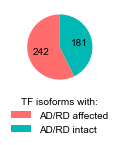

In [19]:
fig = plt.gcf()
fig.set_size_inches(1.5, 1.5)
(df.groupby('alt_iso')
['is_affected'].any()
.value_counts()
.plot.pie(startangle=90,
autopct=lambda x: int(x / 100 * df.loc[df['accession'].str.startswith('RegDom_'), 'alt_iso'].nunique()),
colors=['#FF6D6D', '#00B8B4'],
labels=[' ', ' ']))
plt.legend(labels=['AD/RD affected', 'AD/RD intact'],
           title='TF isoforms with:',
           frameon=False,
           loc='upper center',
           bbox_to_anchor=[0.5, 0],
           )
plt.ylabel('')
plt.savefig('../../figures/for_Marthas_CSBC_talk_2020-09-16/regulatory-domain-affected_TFiso1.0_pie.pdf',
            bbox_inches='tight')

In [25]:
df_null = pd.concat([tfs[row['gene']].null_fraction_per_aa_feature(row['iso_id']) 
for _i, row in remapped.loc[remapped['pct_match'] == 100, ['gene', 'iso_id']].drop_duplicates().iterrows()])
df = pd.merge(df, df_null, on=['gene', 'ref_iso', 'alt_iso', 'accession'], how='left')

In [41]:
df['category'] = df['accession'].str.slice(7).map(doms['type'])
df.head()

,gene,ref_iso,alt_iso,accession,deletion,insertion,frameshift,length,is_affected,null_fraction_affected,category
0,AEBP2,AEBP2-2,AEBP2-3,RegDom_AEBP2_1,38,0,0,85,True,0.224044,Repression
1,ARNTL,ARNTL-1,ARNTL-2,RegDom_ARNTL_1,0,0,0,45,False,0.179310,Activation
2,ARNTL,ARNTL-2,ARNTL-1,RegDom_ARNTL_1,0,0,0,45,False,0.177893,Activation
3,ATF3,ATF3-1,ATF3-2,RegDom_ATF3_1,0,0,0,40,False,0.460993,Activation
4,ATF3,ATF3-1,ATF3-2,RegDom_ATF3_2,0,0,0,45,False,0.477941,Repression


In [42]:
doms = df.groupby('category')['alt_iso'].nunique().to_frame(name='n_alt_iso')
doms['k'] = df.groupby(['category', 'alt_iso'])['is_affected'].any().sum(level='category')
doms['f'] = doms['k'] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


null_p = df.groupby(['category', 'alt_iso'])['null_fraction_affected'].apply(prob_or)
doms['null_99CI_low'] = null_p.groupby('category').apply(null_quantile, 0.01)
doms['null_99CI_high'] = null_p.groupby('category').apply(null_quantile, 0.99)
doms['null_center'] = null_p.groupby('category').apply(null_quantile, 0.5)
doms.head()

,n_alt_iso,k,f,null_99CI_low,null_99CI_high,null_center
category,,,,,,
Activation,238,101.0,0.424370,0.428571,0.542017,0.483193
Repression,161,58.0,0.360248,0.347826,0.490683,0.422360
Predicted repression,117,46.0,0.393162,0.529915,0.666667,0.598291
DNA binding inhibition,7,2.0,0.285714,0.142857,0.714286,0.428571
Regulatory,6,0.0,0.000000,0.000000,0.500000,0.166667


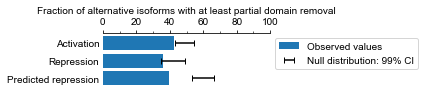

In [45]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 1)
cutoff = 30
data = doms.loc[doms['n_alt_iso'] > cutoff, :].copy()
ax.barh(data.index, 
        data['f'].values * 100,
        label='Observed values')
ax.errorbar(y=data.index,
            x=data['null_center'].values * 100,
            xerr=[(data['null_center'] - data['null_99CI_low']).values * 100,
                  (data['null_99CI_high'] - data['null_center']).values * 100],
                          fmt='none',
                          capsize=3,
                          color='black',
                        label='Null distribution: 99% CI')
ax.legend(loc='upper left', 
          bbox_to_anchor=(1, 1))
ax.set_yticklabels(data.index.values)
ax.set_xlim(0, 100)
ax.set_ylim(ax.get_ylim()[::-1])
ax.yaxis.set_tick_params(length=0)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.set_xlabel('Fraction of alternative isoforms with at least partial domain removal')
ax.xaxis.set_label_position('top')
ax.set_xticks(range(0, 101, 20))
ax.set_xticks(range(0, 101, 10), minor=True)
plt.savefig('../../figures/regulatory-domains-partial-removal_TFiso1_bar-with-null.pdf',
            bbox_inches='tight')

In [ ]:
# table of domain changes
# take case where domain is largest
# alignment?

In [225]:
dbd = pd.read_csv('../../data/190914_6K_affect_of_mapped_uniprot_dbds_with_flank_for_juan.tsv',
                 sep='\t')
dbd.head()

,gene,isoacc,dbd_pfam_acc,dbd_name,dom_start_idx,dom_end_idx,prot_cmp_block_string,prot_cmp_string,dom_len,num_match,%AA_preserved_denom_dom_len
0,LHX6,LHX6|1/4|03D01,PF00046,Homeodomain,234.0,320.0,M,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,87,100.000000
1,LHX6,LHX6|4/4|11G11,PF00046,Homeodomain,205.0,291.0,M,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,87,100.000000
2,LHX6,LHX6|3/4|02B12,PF00046,Homeodomain,205.0,291.0,M,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,87,100.000000
3,LHX6,LHX6|2/4|02C12,PF00046,Homeodomain,205.0,291.0,M,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,87,100.000000
4,LHX8,LHX8|1/2|12A10,PF00046,Homeodomain,211.0,297.0,MR,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,86,98.850575


In [226]:
dbd.dbd_name.unique()

array(['Homeodomain', 'T-box', 'GATA', 'bHLH', 'E2F_TDP', 'HMG_box',
       'Ets', 'MH1', 'Rel', 'Forkhead', 'ARID/BRIGHT', 'TEA', 'TBP',
       'bZIP', 'WT1', 'RFX', 'HSF', 'IPT/TIG', 'p53', 'IRF',
       'MADS box/SRF-TF', 'Myb/SANT', 'THAP finger', 'CBFD_NFYB_HMF',
       'EBF1', 'POU', 'SAND', 'PAX', 'STAT', 'AP-2', 'CP2', 'Runt',
       'Pipsqueak'], dtype=object)

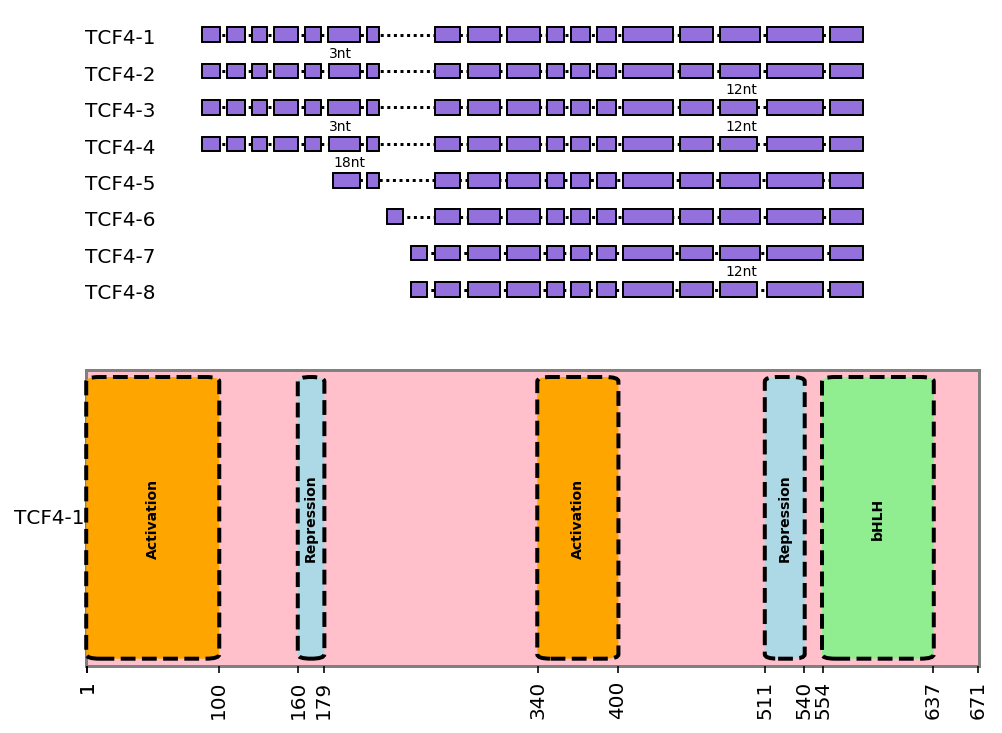

In [252]:
# make a function to visualize the domains
from matplotlib import pyplot as plt
from matplotlib import patches

from plotting import isoform_box_and_line_drawing, isoform_display_name


def domain_fig(seq_len,
               domain_pos,
               domain_labels=None,
               protein_name=None,
               colors=None,
               protein_color='pink',
               ax=None):
    # deal with overlaps
    # dimensions
    # options to control rotation
    if ax is None:
        ax = plt.gca()
    if colors is None:
        colors = ['orange'] * len(domain_pos)
    ax.set_ylim(0, 1)
    ax.set_xlim(0.5, seq_len + 0.5)
    height = 1
    prot = patches.Rectangle((0.5, 0.5 - height / 2),
                             width=seq_len,
                             height=height,
                             clip_on=False,
                             facecolor=protein_color,
                             edgecolor='grey',
                             linewidth=1.5)
    ax.add_patch(prot)
    if domain_labels is None:
        domain_labels = [''] * len(domain_pos)
    for (start, stop), lab, color in zip(domain_pos, domain_labels, colors):
        ax.add_patch(patches.FancyBboxPatch((start - 0.5, 0.5 - (height * 0.95) / 2),
                                       width=(stop - start) + 1,
                                       height=height*0.95,
                                       clip_on=False,
                                       facecolor=color,
                                       boxstyle='round,pad=0,rounding_size=10',
                                       mutation_aspect=1/seq_len,
                                       edgecolor='black',
                                       linewidth=2,
                                       linestyle='--'
                                      ))
        ax.text(x=start + (stop - start) / 2,
                y=0.5,
                s=lab,
                ha='center',
                va='center',
                fontweight='bold',
                fontsize=7,
                rotation=90,)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.spines['bottom'].set_position(('data', 0.5 - height / 2))
    ax.set_xticks([1] + [i for ij in domain_pos for i in ij] + [seq_len])
    ax.xaxis.set_tick_params(rotation=90)
    
    ax.set_yticks([])
    if protein_name is not None:
        ax.text(x=-0.5,
                y=0.5,
                s=protein_name,
                horizontalalignment='right',
                verticalalignment='center')

    

#iso_id = 'PKNOX1|1/4|11H11'
gene = 'TCF4'
iso_id = iso.loc[iso['gene'] == gene, 'clone_acc'].iloc[0]
#gene = iso_id.split('|')[0]
num_aa = iso.loc[iso['clone_acc'] == iso_id, 'aa_seq'].str.len().values[0]


pos = list(remapped.loc[remapped['clone_acc'] == iso_id, ['start', 'end']].values)
pos += list(dbd.loc[dbd['isoacc'] == iso_id, ['dom_start_idx', 'dom_end_idx']].values)

labs = remapped.loc[remapped['clone_acc'] == iso_id, 'reg_dom_id'].map(doms['type']).to_list()
labs += dbd.loc[dbd['isoacc'] == iso_id, 'dbd_name'].to_list()


dom_colors = {'Activation': 'orange',
              'Repression': 'lightblue',
              'bHLH': 'lightgreen'}
# {k: 'lightgreen' for k in dbd['dbd_name'].unique()}
fig, axes = plt.subplots(2, 1)#sharex=True)
fig.set_size_inches(8, 6)
domain_fig(num_aa, 
           pos, 
           labs,
           colors=[dom_colors.get(lab, 'lightgreen') for lab in labs],
           protein_name=isoform_display_name(iso_id),
           ax=axes[1])
# try plotting next to exon structure
isoform_box_and_line_drawing(gene, 
                             iso.loc[iso['gene'] == gene, 'clone_acc'].unique(),
                             ax=axes[0])
# TCF4 is a difficult example because there are insertions and deletions....
# Get other PFam domains
# check why HEY2|2/2|05C07 gives error
# get the ZF domains